In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from surprise import NMF, SVDpp, SVD, Reader, KNNWithZScore
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader
from surprise.accuracy import mae
import numpy as np
from datetime import datetime

In [2]:
import pandas as pd

# Load train and test CSV files into DataFrames
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

train_df.sample(10)

,user,item,rating
287444,54851,44661,6.0
54201,6724,136058,7.0
62878,7906,150562,5.0
322531,62677,160710,6.0
94688,13440,920,7.0
137983,23075,69003,8.0
53757,6652,128601,8.0
133444,21989,37309,6.0
175697,31243,29566,6.0
5083,534,39024,7.0


<Axes: title={'center': 'Rating Distribution'}, xlabel='Rating', ylabel='Count'>

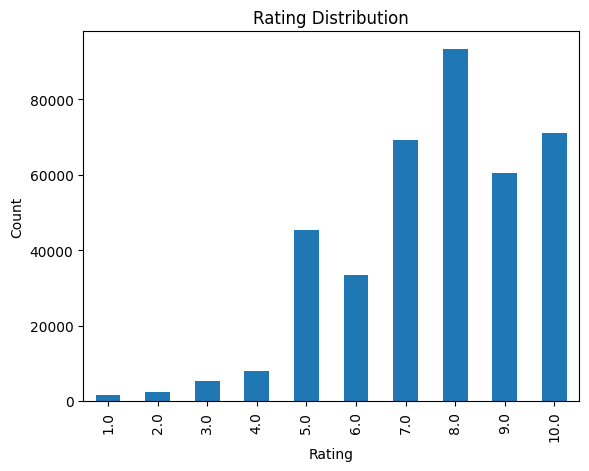

In [3]:
rating_distribution = train_df['rating'].value_counts().sort_index()
rating_distribution.plot(kind='bar', title='Rating Distribution', xlabel='Rating', ylabel='Count')

In [4]:
# Convert the train DataFrame to a Surprise dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the SVD++ algorithm on the trainset
svdpp = SVDpp(n_factors=4, lr_all=0.007, reg_all=0.1)
svdpp.fit(trainset)

# Train the SVD algorithm on the trainset
svd = SVD(n_factors=20, lr_all=0.005, reg_all=0.02)
svd.fit(trainset)

# Train the NMF algorithm on the trainset
nmf = NMF(n_factors=20, reg_pu=0.1, reg_qi=0.1)
nmf.fit(trainset)

# Predict ratings for the testset
svdpp_predictions = svdpp.test(testset)
svd_predictions = svd.test(testset)
nmf_predictions = nmf.test(testset)

# Prepare training data for the neural network
X_train = []
y_train = []
for (uid, iid, true_r) in trainset.build_testset():
    svdpp_pred = svdpp.predict(uid, iid).est
    svd_pred = svd.predict(uid, iid).est
    nmf_pred = nmf.predict(uid, iid).est
    X_train.append([svdpp_pred, svd_pred, nmf_pred])
    y_train.append(true_r)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

class EnsembleNN(nn.Module):
    def __init__(self):
        super(EnsembleNN, self).__init__()
        self.fc1 = nn.Linear(3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 1)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.gelu(self.fc1(x))
        x = self.gelu(self.fc2(x))
        x = self.gelu(self.fc3(x))
        x = self.gelu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the neural network, loss function, and optimizer
model = EnsembleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Prepare test data for the neural network
X_test = []
y_test = []
for (uid, iid, true_r) in testset:
    svdpp_pred = svdpp.predict(uid, iid).est
    svd_pred = svd.predict(uid, iid).est
    nmf_pred = nmf.predict(uid, iid).est
    X_test.append([svdpp_pred, svd_pred, nmf_pred])
    y_test.append(true_r)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader for testing
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the neural network on the test set
model.eval()
total_abs_error = 0
total_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_predictions = model(batch_X).view(-1)
        batch_abs_error = torch.abs(batch_predictions - batch_y.view(-1))
        total_abs_error += batch_abs_error.sum().item()
        total_samples += batch_y.size(0)

# Calculate MAE for the neural network ensemble
nn_mae = total_abs_error / total_samples
svdpp_mae = mae(svdpp_predictions, verbose=False)
svd_mae = mae(svd_predictions, verbose=False)
nmf_mae = mae(nmf_predictions, verbose=False)

print(f"SVD++ MAE: {svdpp_mae}")
print(f"SVD MAE: {svd_mae}")
print(f"NMF MAE: {nmf_mae}")
print(f"Neural Network Ensemble MAE: {nn_mae}")

Epoch 1/100, Loss: 57.322120666503906
Epoch 2/100, Loss: 52.87934875488281
Epoch 3/100, Loss: 47.42179870605469
Epoch 4/100, Loss: 41.25749206542969
Epoch 5/100, Loss: 34.88716506958008
Epoch 6/100, Loss: 28.562435150146484
Epoch 7/100, Loss: 22.25969886779785
Epoch 8/100, Loss: 16.04414939880371
Epoch 9/100, Loss: 10.258626937866211
Epoch 10/100, Loss: 5.433461666107178
Epoch 11/100, Loss: 2.1738979816436768
Epoch 12/100, Loss: 1.0532234907150269
Epoch 13/100, Loss: 2.2571914196014404
Epoch 14/100, Loss: 4.831497669219971
Epoch 15/100, Loss: 6.790708541870117
Epoch 16/100, Loss: 6.858800411224365
Epoch 17/100, Loss: 5.237879276275635
Epoch 18/100, Loss: 2.999549150466919
Epoch 19/100, Loss: 1.3299148082733154
Epoch 20/100, Loss: 0.9753303527832031
Epoch 21/100, Loss: 1.8015635013580322
Epoch 22/100, Loss: 2.7548365592956543
Epoch 23/100, Loss: 3.053743362426758
Epoch 24/100, Loss: 2.6749560832977295
Epoch 25/100, Loss: 1.949217677116394
Epoch 26/100, Loss: 1.254333734512329
Epoch 27/1

In [5]:
# Prepare the test set for predictions
testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]

# Generate predictions for each model
X_test = []
for (uid, iid, true_r) in testset:
    svdpp_pred = svdpp.predict(uid, iid).est
    svd_pred = svd.predict(uid, iid).est
    nmf_pred = nmf.predict(uid, iid).est
    X_test.append([svdpp_pred, svd_pred, nmf_pred])

# Convert test data to a tensor
X_test = torch.tensor(X_test, dtype=torch.float32)

# Use the trained neural network to predict ratings
model.eval()
with torch.no_grad():
    nn_predictions = model(X_test).view(-1).numpy()

# Update the test DataFrame with the neural network predictions
for i, pred in enumerate(nn_predictions):
    test_df.at[i, 'rating'] = round(pred)

# Prepare the output file path with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/Ensemble/predicciones_ensemble_nn_{timestamp}.csv'

# Export the result to a CSV file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/Ensemble/predicciones_ensemble_nn_20250331_182521.csv


,ID,user,item,rating
42427,42427,9654,18846,4.0
9444,9444,4201,13040,5.0
33568,33568,5739,16333,9.0
24388,24388,10845,1819,9.0
92,92,4201,12666,9.0
37940,37940,11423,2671,9.0
25859,25859,4646,5199,9.0
31781,31781,10055,571,8.0
1914,1914,2926,9742,9.0
38598,38598,9075,801,9.0
